# Multi-touch Multi-channel Attribution Model Using LSTM with Attention

This is an attribution model that uses LSTM with attention to assign weights to touchpoints. 

| Description | D001 (see [descriptions](https://github.com/ikatsov/tensor-house/blob/master/resources/descriptions.md)) |
|--|:--|
| Dataset | Criteo (see [datasets](https://github.com/ikatsov/tensor-house/blob/master/resources/datsets.md)) |
| Papers | Li2018, Ren2018 (see [papers](https://github.com/ikatsov/tensor-house/blob/master/resources/papers.md)) | 
| Installation | Download the dataset to 'data' folder |
| Libs | Keras, Scikit-learn, Pandas, Numpy |

### Data description
This dataset represents a sample of 30 days of Criteo live traffic data. Each line corresponds to one impression (a banner) that was displayed to a user. For each banner we have detailed information about the context, if it was clicked, if it led to a conversion and if it led to a conversion that was attributed to Criteo or not. Data has been sub-sampled and anonymized so as not to disclose proprietary elements.

Here is a detailed description of the fields (they are tab-separated in the file):

* timestamp: timestamp of the impression (starting from 0 for the first impression). The dataset is sorted according to timestamp.
* uid: a unique user identifier
* campaign: a unique identifier for the campaign
* conversion: 1 if there was a conversion in the 30 days after the impression (independently of whether this impression was last click or not)
* conversion_timestamp: the timestamp of the conversion or -1 if no conversion was observed
* conversion_id: a unique identifier for each conversion (so that timelines can be reconstructed if needed). -1 if there was no conversion
* attribution: 1 if the conversion was attributed to Criteo, 0 otherwise
* click: 1 if the impression was clicked, 0 otherwise
* click_pos: the position of the click before a conversion (0 for first-click)
* click_nb: number of clicks. More than 1 if there was several clicks before a conversion
* cost: the price paid by Criteo for this display (disclaimer: not the real price, only a transformed version of it)
* cpo: the cost-per-order in case of attributed conversion (disclaimer: not the real price, only a transformed version of it)
* time_since_last_click: the time since the last click (in s) for the given impression
* cat(1-9): contextual features associated to the display. Can be used to learn the click/conversion models. We do not disclose the meaning of these features but it is not relevant for this study. Each column is a categorical variable. In the experiments, they are mapped to a fixed dimensionality space using the Hashing Trick (see paper for reference).

### Key figures
* 2.4Gb uncompressed
* 16.5M impressions
* 45K conversions
* 700 campaigns

In [52]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#import keras

plt.style.use('ggplot')

In [18]:
# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
data_file = "C:/Users/16176/Documents/MS DAE Material/INFO 7374  ADM/criteo_attribution_dataset.tsv/sample_pcb.tsv"
df0 = pd.read_csv(data_file)

n_campaigns = 400

df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

108174
[54134, 54040]


In [35]:
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

In [50]:
df6.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,...,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns
81452,12,28883743,24267774,0,-1,-1,0,1,-1,-1,...,3808271,28928366,9312274,29196072,29196072,28883743_-1,0.000003,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
14272,16,14158457,1415896,0,-1,-1,0,0,-1,-1,...,11409686,29196072,15513380,29196072,29196072,14158457_-1,0.000005,0.000000,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
78985,19,24850810,10810197,0,-1,-1,0,1,-1,-1,...,11409684,1973606,12856719,20754144,32145478,24850810_-1,0.000006,0.000698,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
22277,30,9451380,17321082,1,355909,4136014,0,1,1,3,...,5824237,30763035,7230114,29196072,21091111,9451380_4136014,0.000010,0.140297,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
21031,31,30607637,24045148,0,-1,-1,0,0,-1,-1,...,32440044,32440053,9312274,29196072,29196072,30607637_-1,0.000010,0.000000,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [54]:
try1=df6.head()
for cname in ('uid','campaign'):
    x = df6[cname].values.reshape(-1, 1)
    try1[cname + '_norm'] = Min_Max_scaler.fit_transform(x)

NameError: name 'Min_Max_scaler' is not defined

In [37]:
a={'omk':1,'san':2}

In [39]:
a['lkk']=len(a)

In [41]:
a['lkk']

2

## Last Touch Attribution

In [63]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)

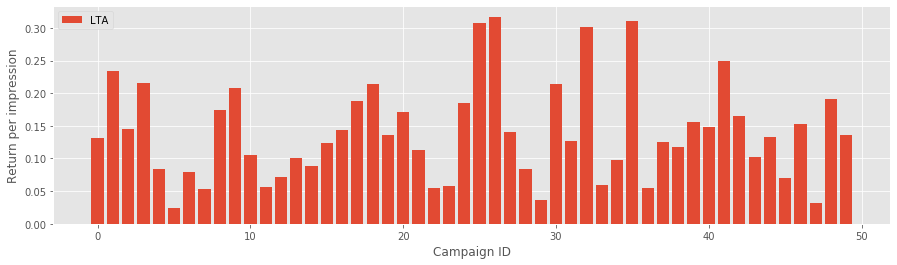

In [64]:
# Visualization of the attribution scores

campaign_idx = range(150,200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [65]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
def linear_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    campaign_conversions = count_by_campaign(df_converted)        
    return campaign_conversions / campaign_impressions
    
lin = linear_attribution(df6)

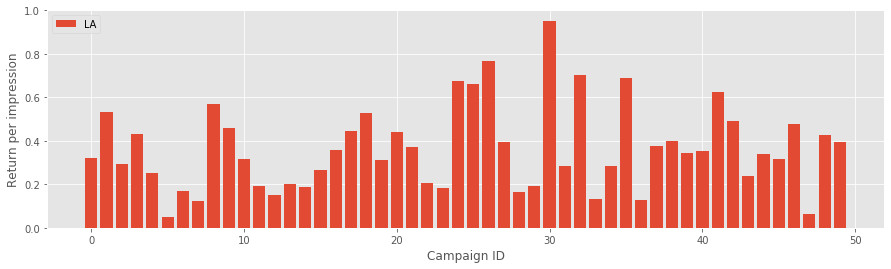

In [66]:
campaign_idx = range(150, 200)
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(lin[campaign_idx])), lin[campaign_idx], label='LA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

## Logistic Regression

In [201]:
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [202]:
x, y = features_for_logistic_regression(df6)
print(np.shape(x))

(145440, 1561)


In [203]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [204]:
# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

0.8653396589658966


In [205]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 93081 samples, validate on 23271 samples
Epoch 1/10
93081/93081 [==============================] - 3s 30us/step - loss: 0.5277 - acc: 0.7693 - val_loss: 0.4710 - val_acc: 0.8031
Epoch 2/10
93081/93081 [==============================] - 1s 12us/step - loss: 0.4442 - acc: 0.8172 - val_loss: 0.4363 - val_acc: 0.8172
Epoch 3/10
93081/93081 [==============================] - 1s 12us/step - loss: 0.4183 - acc: 0.8293 - val_loss: 0.4180 - val_acc: 0.8290
Epoch 4/10
93081/93081 [==============================] - 1s 13us/step - loss: 0.4032 - acc: 0.8367 - val_loss: 0.4066 - val_acc: 0.8343
Epoch 5/10
93081/93081 [==============================] - 1s 14us/step - loss: 0.3931 - acc: 0.8416 - val_loss: 0.3984 - val_acc: 0.8383
Epoch 6/10
93081/93081 [==============================] - 1s 13us/step - loss: 0.3853 - acc: 0.8443 - val_loss: 0.3931 - val_acc: 0.8410
Epoch 7/10
93081/93081 [==============================] - 1s 13us/step - loss: 0.3795 - acc: 0.8471 - val_loss: 0.3875 - val_acc

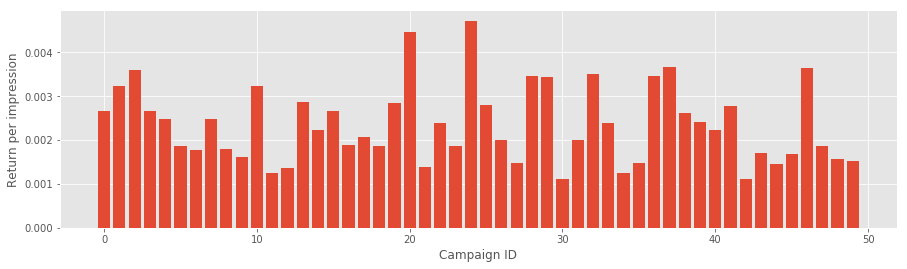

In [207]:
# Visualization of the attribution scores
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

## Basic LSTM

In [208]:
def features_for_lstm(df, max_touchpoints):
    
    df_proj = df[['jid', 'campaigns', 'cats', 'click', 'cost', 'time_since_last_click_norm', 'timestamp_norm', 'conversion']]
    
    x2d = df_proj.values
    
    x3d_list = np.split(x2d[:, 1:], np.cumsum(np.unique(x2d[:, 0], return_counts=True)[1])[:-1])
    
    x3d = []
    y = []
    for xi in x3d_list:
        journey_matrix = np.apply_along_axis(np.hstack, 1, xi)
        journey_matrix = journey_matrix[ journey_matrix[:, 5].argsort() ] # sort impressions by timestamp
        n_touchpoints = len(journey_matrix)
        padded_journey = []
        if(n_touchpoints >= max_touchpoints):
            padded_journey = journey_matrix[0:max_touchpoints]
        else:
            padded_journey = np.pad(journey_matrix, ((0, max_touchpoints - n_touchpoints), (0, 0)), 'constant', constant_values=(0))
            
        x3d.append(padded_journey[:, 0:-1])
        y.append(np.max(padded_journey[:, -1]))
        
    return np.stack(x3d), y

x, y = features_for_lstm(df6, max_touchpoints = 15)
print(np.shape(x))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

(145440, 15, 1563)


In [211]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM

n_steps, n_features = np.shape(x)[1:3]
    
model = Sequential() 
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, input_shape=(n_steps, n_features)))
model.add(Dense(1, activation='sigmoid')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=64, epochs=5, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 93081 samples, validate on 23271 samples
Epoch 1/5
93081/93081 [==============================] - 135s 1ms/step - loss: 0.3033 - acc: 0.8677 - val_loss: 0.2547 - val_acc: 0.8899
Epoch 2/5
93081/93081 [==============================] - 152s 2ms/step - loss: 0.2603 - acc: 0.8879 - val_loss: 0.2322 - val_acc: 0.9013
Epoch 3/5
93081/93081 [==============================] - 160s 2ms/step - loss: 0.2415 - acc: 0.8979 - val_loss: 0.2274 - val_acc: 0.9069
Epoch 4/5
93081/93081 [==============================] - 156s 2ms/step - loss: 0.2293 - acc: 0.9047 - val_loss: 0.2091 - val_acc: 0.9129
Epoch 5/5
93081/93081 [==============================] - 155s 2ms/step - loss: 0.2248 - acc: 0.9067 - val_loss: 0.2136 - val_acc: 0.9112
Test score: 0.21668663059081575
Test accuracy: 0.9088627612761276


## LSTM with Attention

In [236]:
from keras.models import Sequential 
from keras.layers import Dense, LSTM, Input, Lambda, RepeatVector, Permute, Flatten, Activation, Multiply
from keras.constraints import NonNeg
from keras import backend as K
from keras.models import Model

n_steps, n_features = np.shape(x)[1:3]

hidden_units = 64

main_input = Input(shape=(n_steps, n_features))
    
embeddings = Dense(128, activation='linear', input_shape=(n_steps, n_features))(main_input)

activations = LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embeddings)

attention = Dense(1, activation='tanh')(activations)
attention = Flatten()(attention)
attention = Activation('softmax', name = 'attention_weigths')(attention)
attention = RepeatVector(hidden_units * 1)(attention)
attention = Permute([2, 1])(attention)

weighted_activations = Multiply()([activations, attention])
weighted_activations = Lambda(lambda xin: K.sum(xin, axis=-2), output_shape=(hidden_units,))(weighted_activations)

main_output = Dense(1, activation='sigmoid')(weighted_activations)

model = Model(inputs=main_input, outputs=main_output)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=64, epochs=5, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 93081 samples, validate on 23271 samples
Epoch 1/5
93081/93081 [==============================] - 110s 1ms/step - loss: 0.2293 - acc: 0.9018 - val_loss: 0.2162 - val_acc: 0.9110
Epoch 2/5
93081/93081 [==============================] - 109s 1ms/step - loss: 0.2001 - acc: 0.9152 - val_loss: 0.2038 - val_acc: 0.9123
Epoch 3/5
93081/93081 [==============================] - 96s 1ms/step - loss: 0.1906 - acc: 0.9199 - val_loss: 0.2002 - val_acc: 0.9166
Epoch 4/5
93081/93081 [==============================] - 85s 910us/step - loss: 0.1876 - acc: 0.9213 - val_loss: 0.1949 - val_acc: 0.9168
Epoch 5/5
93081/93081 [==============================] - 98s 1ms/step - loss: 0.1846 - acc: 0.9222 - val_loss: 0.1924 - val_acc: 0.9190
Test score: 0.19408383931476947
Test accuracy: 0.9186262376237624


## Analysis of LSTM-A Model

In [238]:
def get_campaign_id(x_journey_step):
    return np.argmax(x_journey_step[0:n_campaigns])

attention_model = Model(inputs=model.input, outputs=model.get_layer('attention_weigths').output)

a = attention_model.predict(x_train)

attributions = np.zeros(n_campaigns)
campaign_freq = np.ones(n_campaigns)
for i, journey in enumerate(a):
    for step, step_contribution in enumerate(journey):
        if(np.sum(x_train[i][step]) > 0):
            campaign_id = get_campaign_id(x_train[i][step])
            attributions[campaign_id] = attributions[campaign_id] + step_contribution
            campaign_freq[campaign_id] = campaign_freq[campaign_id] + 1

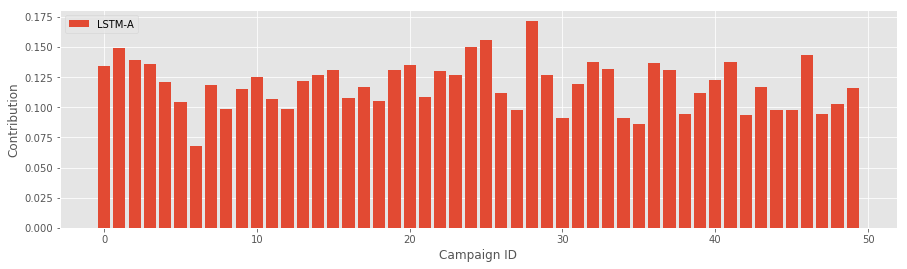

In [239]:
lstm_a = (attributions/campaign_freq)

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
plt.bar( range(len(lstm_a[campaign_idx])), lstm_a[campaign_idx], label='LSTM-A' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

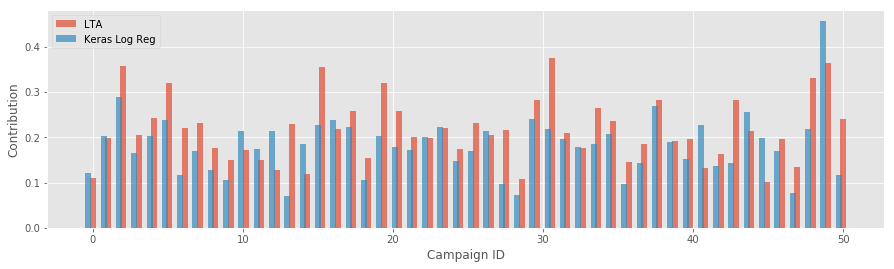

In [133]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

ratio = max(lta[idx]) / max(keras_logreg[idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, keras_logreg[campaign_idx], width=0.4, alpha=0.7, label='Keras Log Reg' )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

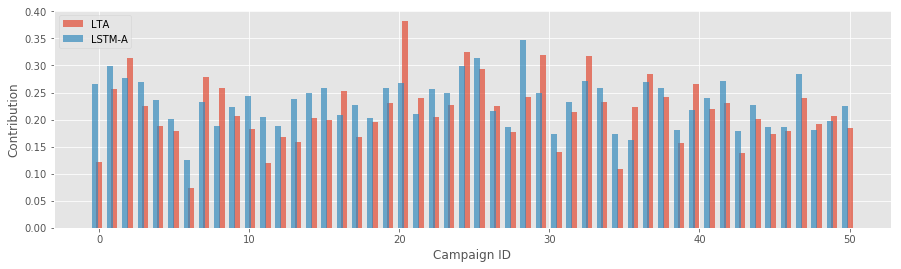

In [240]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(111)

ratio = max(lta[campaign_idx]) / max(lstm_a[campaign_idx])
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)), lta[campaign_idx], width=0.4, alpha=0.7, label='LTA' )
plt.bar(np.linspace(0, len(campaign_idx), len(campaign_idx)) - 0.3, lstm_a[campaign_idx], width=0.4, alpha=0.7, label='LSTM-A'  )
plt.xlabel('Campaign ID')
plt.ylabel('Contribution')
plt.legend(loc='upper left')
plt.show()

## Simulation

In [226]:
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [ ]:
pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta, keras_logreg, lstm_a]

for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
        print('{} {} : {}'.format(p, j, reward))